In [2]:
import numpy as np
import torch
import tqdm
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from widis_lstm_tools.nn import LSTMLayer

# Prepare some random generators for later
rnd_gen = np.random.RandomState(seed=123)
_ = torch.manual_seed(123)

In [15]:
class Environment(Dataset):
    def __init__(self, n_samples: int, max_timestep: int, n_positions: int, rnd_gen: np.random.RandomState):
        """Our simple 1D environment as PyTorch Dataset"""
        super(Environment, self).__init__()
        n_actions = 2
        
        # C'est juste les règles du jeu et rien d'autre. Zéro position c'est la position de départ du joueur
        zero_position = int(np.ceil(n_positions / 2.))
        coin_position = zero_position + 2
        
        # Generate random action sequences. Génère une séquence d'action aléatoire de soit 0 ou 1.
        # Une ligne représente une séquence complète d'actions
        actions = np.asarray(rnd_gen.randint(low=0, high=2, size=(n_samples, max_timestep)), dtype=np.int)
            
        # Si l'agent a joué l'action 0 alors on prend l'identité, soit [1,0]
        # Si l'agent a joué l'action 1 alors on prend l'identité, soit [0,1]
        actions_onehot = np.identity(n_actions, dtype=np.float32)[actions]
        
        # Generate observations from action sequences
        # Ça permet de convertir une action 0 en -1 et l'action 1 reste là même. On va avoir une matrice de -1 et 1.
        # Ça permet de faire déplacer l'agent.
        actions[:] = (actions * 2) - 1
        
        # On génère 1000 samples dont la trajectoire est de 50 pas. Donc la simulation est de 50 steps au maximum
        observations = np.full(fill_value=zero_position, shape=(n_samples, max_timestep), dtype=np.int)
        
        print(observations.shape)
        
        # On prend toutes les actions au temps 1
        for t in range(max_timestep-1):
            action = actions[:, t]
            
            # Essentiellement ce que ça fait c'est que ça additionne les actions au observations et ça clip 
            # les observations entre 0 et la position n-1, c'est juste pour la simulation et pas pour notre problème. 
            observations[:, t+1] = np.clip(observations[:, t] + action, 0, n_positions-1)
            
        observations_onehot = np.identity(n_positions, dtype=np.float32)[observations]
        
        # On veut donc avoir ici la position du joueur
        print(np.identity(n_positions, dtype=np.float32))
        print(observations_onehot.shape)
        print(observations.shape)
        
        # Calculate rewards (sum over coin position for all timesteps)
        rewards = np.zeros(shape=(n_samples, max_timestep), dtype=np.float32)
        rewards[:, -1] = observations_onehot[:, :, coin_position].sum(axis=1)
        
        self.actions = actions_onehot
        self.observations = observations_onehot
        self.rewards = rewards
        
    def __len__(self):
        return self.rewards.shape[0]
    
    def __getitem__(self, idx):
        return self.observations[idx], self.actions[idx], self.rewards[idx]


n_positions = 13
env = Environment(n_samples=1000, max_timestep=50, n_positions=13, rnd_gen=rnd_gen)
env_loader = torch.utils.data.DataLoader(env, batch_size=8)

(1000, 50)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1000, 50, 13)
(1000, 50)


(50, 13) (50, 2) (50,)


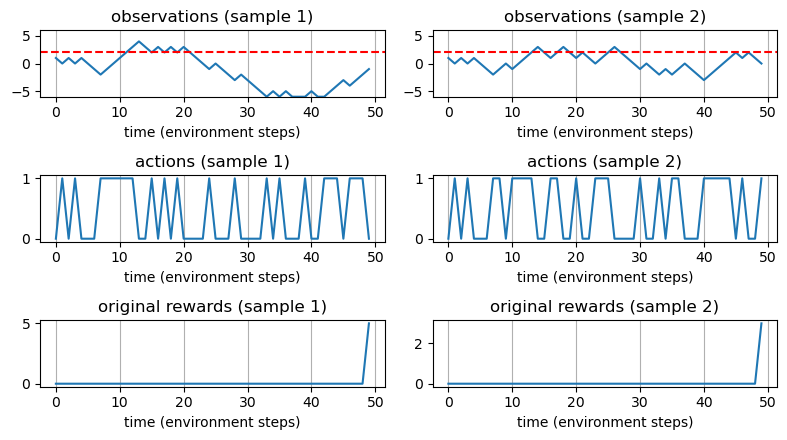

In [16]:
# obs0, a0 et r0 sont des séquences complètes. C'est l'historique d'une trajectoire !!
obs0, a0, r0 = env.__getitem__(3)
obs1, a1, r1 = env.__getitem__(25)

print(obs1.shape, a1.shape, r1.shape)

fig, axes = plt.subplots(3, 2, figsize=(8, 4.5), dpi=100)
axes[0, 0].plot(obs0.argmax(-1) - 6)
axes[0, 1].plot(obs1.argmax(-1) - 6)
axes[0, 0].set_ylim(-6, 6)
axes[0, 1].set_ylim(-6, 6)
axes[0, 0].axhline(2, linestyle='--', color='r')
axes[0, 1].axhline(2, linestyle='--', color='r')
axes[0, 0].xaxis.grid(True)
axes[0, 1].xaxis.grid(True)
axes[0, 0].set_title('observations (sample 1)')
axes[0, 1].set_title('observations (sample 2)')
axes[0, 0].set_xlabel('time (environment steps)')
axes[0, 1].set_xlabel('time (environment steps)')

axes[1, 0].plot(a0.argmax(-1))
axes[1, 1].plot(a1.argmax(-1))
axes[1, 0].xaxis.grid(True)
axes[1, 1].xaxis.grid(True)
axes[1, 0].set_title('actions (sample 1)')
axes[1, 1].set_title('actions (sample 2)')
axes[1, 0].set_xlabel('time (environment steps)')
axes[1, 1].set_xlabel('time (environment steps)')

axes[2, 0].plot(r0)
axes[2, 1].plot(r1)
axes[2, 0].xaxis.grid(True)
axes[2, 1].xaxis.grid(True)
axes[2, 0].set_title('original rewards (sample 1)')
axes[2, 1].set_title('original rewards (sample 2)')
axes[2, 0].set_xlabel('time (environment steps)')
axes[2, 1].set_xlabel('time (environment steps)')

fig.tight_layout()

In [11]:
class Net(torch.nn.Module):
    def __init__(self, n_positions, n_actions, n_lstm):
        super(Net, self).__init__()
        
        # This will create an LSTM layer where we will feed the concatenate
        self.lstm1 = LSTMLayer(
            in_features=n_positions+n_actions, out_features=n_lstm, inputformat='NLC',
            # cell input: initialize weights to forward inputs with xavier, disable connections to recurrent inputs
            w_ci=(torch.nn.init.xavier_normal_, False),
            # input gate: disable connections to forward inputs, initialize weights to recurrent inputs with xavier
            w_ig=(False, torch.nn.init.xavier_normal_),
            # output gate: disable all connection (=no forget gate) and disable bias
            w_og=False, b_og=False,
            # forget gate: disable all connection (=no forget gate) and disable bias
            w_fg=False, b_fg=False,
            # LSTM output activation is set to identity function
            a_out=lambda x: x
        )
        
        # After the LSTM layer, we add a fully connected output layer
        self.fc_out = torch.nn.Linear(n_lstm, 1)
    
    def forward(self, observations, actions):
        # Process input sequence by LSTM
        lstm_out, *_ = self.lstm1(torch.cat([observations, actions], dim=-1),
                                  return_all_seq_pos=True  # return predictions for all sequence positions
                                  )
        net_out = self.fc_out(lstm_out)
        return net_out


# Create Network
device = 'cuda:0'
net = Net(n_positions=n_positions, n_actions=2, n_lstm=16)
_ = net.to(device)

In [12]:
def lossfunction(predictions, rewards):
    returns = rewards.sum(dim=1)
    
    # Main task: predicting return at last timestep. 
    # Essentiellement c'est le calcul de MSE
    main_loss = torch.mean(predictions[:, -1] - returns) ** 2
    
    # Auxiliary task: predicting final return at every timestep ([..., None] is for correct broadcasting)
    # Prediction détient une dimension de plus alors il ajoute une dimensions avec returns[..., None]
    # Ça revient à faire returns[:, None] en une dimension
    aux_loss = torch.mean(predictions[:, :] - returns[..., None]) ** 2
    # Combine losses
    # C'est nébuleux pour moi cette loss
    loss = main_loss + aux_loss * 0.5
    return loss

In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

update = 0
n_updates = 5000
running_loss = 100.
progressbar = tqdm.tqdm(total=n_updates)
while update < n_updates:
    for data in env_loader:
        # Get samples
        observations, actions, rewards = data
        observations, actions, rewards = observations.to(device), actions.to(device), rewards.to(device)
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Get outputs for network
        outputs = net(observations=observations, actions=actions)
        
        # Calculate loss, do backward pass, and update
        loss = lossfunction(outputs[..., 0], rewards)
        loss.backward()
        running_loss = running_loss*0.99 + loss*0.01
        optimizer.step()
        update += 1
        progressbar.set_description(f"Loss: {running_loss:8.4f}")
        progressbar.update(1)

progressbar.close()

Loss:   0.3531: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [02:01<00:00, 41.10it/s]


In [29]:

# Load 2 samples
obs0, a0, r0 = env.__getitem__(3)
obs1, a1, r1 = env.__getitem__(25)

# Apply our reward redistribution model to the samples
observations = torch.stack([torch.Tensor(obs0).to(device), torch.Tensor(obs1).to(device)], dim=0)
actions = torch.stack([torch.Tensor(a0).to(device), torch.Tensor(a1).to(device)], dim=0)
rewards = torch.stack([torch.Tensor(r0).to(device), torch.Tensor(r1).to(device)], dim=0)
predictions = net(observations=observations.to(device), actions=actions.to(device))[..., 0]

# Use the differences of predictions as redistributed reward
redistributed_reward = predictions[:, 1:] - predictions[:, :-1]

# For the first timestep we will take (0-predictions[:, :1]) as redistributed reward
redistributed_reward = torch.cat([predictions[:, :1], redistributed_reward], dim=1)

In [30]:
# Calculate prediction error
returns = rewards.sum(dim=1)
predicted_returns = redistributed_reward.sum(dim=1)
prediction_error = returns - predicted_returns

# Distribute correction for prediction error equally over all sequence positions
redistributed_reward += prediction_error[:, None] / redistributed_reward.shape[1]

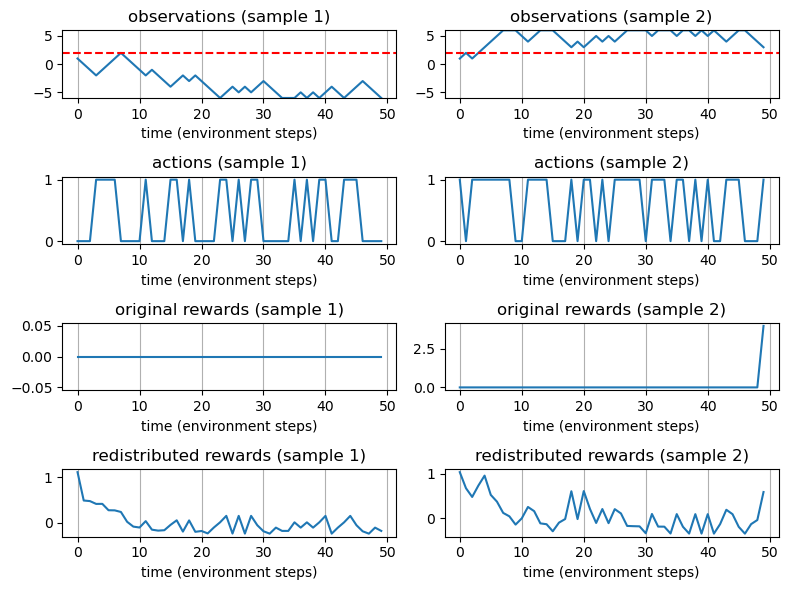

In [31]:
# Let's plot our samples with the redistributed rewards:
redistributed_reward = redistributed_reward.cpu().detach().numpy()
rr0, rr1 = redistributed_reward[0], redistributed_reward[1]

fig, axes = plt.subplots(4, 2, figsize=(8, 6), dpi=100)
axes[0, 0].plot(obs0.argmax(-1) - 6)
axes[0, 1].plot(obs1.argmax(-1) - 6)
axes[0, 0].set_ylim(-6, 6)
axes[0, 1].set_ylim(-6, 6)
axes[0, 0].axhline(2, linestyle='--', color='r')
axes[0, 1].axhline(2, linestyle='--', color='r')
axes[0, 0].xaxis.grid(True)
axes[0, 1].xaxis.grid(True)
axes[0, 0].set_title('observations (sample 1)')
axes[0, 1].set_title('observations (sample 2)')
axes[0, 0].set_xlabel('time (environment steps)')
axes[0, 1].set_xlabel('time (environment steps)')

axes[1, 0].plot(a0.argmax(-1))
axes[1, 1].plot(a1.argmax(-1))
axes[1, 0].xaxis.grid(True)
axes[1, 1].xaxis.grid(True)
axes[1, 0].set_title('actions (sample 1)')
axes[1, 1].set_title('actions (sample 2)')
axes[1, 0].set_xlabel('time (environment steps)')
axes[1, 1].set_xlabel('time (environment steps)')

axes[2, 0].plot(r0)
axes[2, 1].plot(r1)
axes[2, 0].xaxis.grid(True)
axes[2, 1].xaxis.grid(True)
axes[2, 0].set_title('original rewards (sample 1)')
axes[2, 1].set_title('original rewards (sample 2)')
axes[2, 0].set_xlabel('time (environment steps)')
axes[2, 1].set_xlabel('time (environment steps)')

axes[3, 0].plot(rr0)
axes[3, 1].plot(rr1)
axes[3, 0].xaxis.grid(True)
axes[3, 1].xaxis.grid(True)
axes[3, 0].set_title('redistributed rewards (sample 1)')
axes[3, 1].set_title('redistributed rewards (sample 2)')
axes[3, 0].set_xlabel('time (environment steps)')
axes[3, 1].set_xlabel('time (environment steps)')

fig.tight_layout()